# L1 norm prior experiment

This code attempts to learn the 16D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 16

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 370.77520751953125
iteration 0 loss 338.511474609375


iteration 5000 loss 6.116454124450684


iteration 10000 loss 0.6213573217391968


iteration 15000 loss 0.4999169409275055


iteration 20000 loss 0.4345093071460724


iteration 25000 loss 0.38965481519699097


iteration 30000 loss 0.3595896065235138


iteration 35000 loss 0.33427441120147705


iteration 40000 loss 0.2938910126686096


iteration 45000 loss 0.2023899406194687


iteration 50000 loss 0.03965571150183678


iteration 55000 loss 0.020306099206209183


iteration 60000 loss 0.015956932678818703


iteration 65000 loss 0.01379900611937046


iteration 70000 loss 0.012576192617416382


iteration 75000 loss 0.01171804964542389


iteration 80000 loss 0.011177873238921165


iteration 85000 loss 0.010704521089792252


iteration 90000 loss 0.01035529188811779


iteration 95000 loss 0.010046370327472687


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.009774473495781422


iteration 105000 loss 0.009642590768635273


iteration 110000 loss 0.00933024287223816


iteration 115000 loss 0.009067539125680923


iteration 120000 loss 0.008804951794445515


iteration 125000 loss 0.00861533172428608


iteration 130000 loss 0.008440736681222916


iteration 135000 loss 0.008284443989396095


iteration 140000 loss 0.008137686178088188


iteration 145000 loss 0.00800696387887001


iteration 150000 loss 0.007878752425312996


iteration 155000 loss 0.007757000625133514


iteration 160000 loss 0.0076426975429058075


iteration 165000 loss 0.0075272368267178535


iteration 170000 loss 0.007403776980936527


iteration 175000 loss 0.00730174733325839


iteration 180000 loss 0.007204581052064896


iteration 185000 loss 0.007117814384400845


iteration 190000 loss 0.007035534363240004


iteration 195000 loss 0.006954719312489033


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.006877230945974588


iteration 205000 loss 0.0068553173914551735


iteration 210000 loss 0.006764562334865332


iteration 215000 loss 0.006667961832135916


iteration 220000 loss 0.00657565426081419


iteration 225000 loss 0.006488004699349403


iteration 230000 loss 0.006403983570635319


iteration 235000 loss 0.006324206478893757


iteration 240000 loss 0.006246048957109451


iteration 245000 loss 0.006170099135488272


iteration 250000 loss 0.006096518132835627


iteration 255000 loss 0.006025124806910753


iteration 260000 loss 0.0059556723572313786


iteration 265000 loss 0.005888022016733885


iteration 270000 loss 0.005822424776852131


iteration 275000 loss 0.005758151412010193


iteration 280000 loss 0.005695222876966


iteration 285000 loss 0.005633608903735876


iteration 290000 loss 0.005573369562625885


iteration 295000 loss 0.0055145081132650375


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.005457256454974413


iteration 305000 loss 0.005448929034173489


iteration 310000 loss 0.00543931033462286


iteration 315000 loss 0.005429959390312433


iteration 320000 loss 0.005420801695436239


iteration 325000 loss 0.005411808378994465


iteration 330000 loss 0.005402929615229368


iteration 335000 loss 0.005394138861447573


iteration 340000 loss 0.005385424010455608


iteration 345000 loss 0.00537677900865674


iteration 350000 loss 0.00536819314584136


iteration 355000 loss 0.005359666887670755


iteration 360000 loss 0.005351198371499777


iteration 365000 loss 0.005342780612409115


iteration 370000 loss 0.005334413610398769


iteration 375000 loss 0.005326095037162304


iteration 380000 loss 0.00531781604513526


iteration 385000 loss 0.005309578496962786


iteration 390000 loss 0.005301379598677158


iteration 395000 loss 0.005293217021971941


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.005285087041556835


iteration 405000 loss 0.005284739192575216


iteration 410000 loss 0.005284380167722702


iteration 415000 loss 0.005284025799483061


iteration 420000 loss 0.005283670034259558


iteration 425000 loss 0.005283324047923088


iteration 430000 loss 0.005282977130264044


iteration 435000 loss 0.005282636731863022


iteration 440000 loss 0.005282296799123287


iteration 445000 loss 0.005281955003738403


iteration 450000 loss 0.005281617399305105


iteration 455000 loss 0.005281281191855669


iteration 460000 loss 0.005280948244035244


iteration 465000 loss 0.005280614364892244


iteration 470000 loss 0.0052802846767008305


iteration 475000 loss 0.005279954988509417


iteration 480000 loss 0.005279622972011566


iteration 485000 loss 0.005279294680804014


iteration 490000 loss 0.005278967320919037


iteration 495000 loss 0.005278643686324358


L2 loss -- Plot

loss -72.005859375


loss -171.60205078125


loss -262.2105712890625


loss -346.44091796875


loss -420.34765625


loss -478.2112121582031


loss -518.2246704101562


loss -544.1734619140625


loss -560.8006591796875


loss -571.5894775390625


loss -578.8305053710938


loss -583.936279296875


loss -587.7371826171875


loss -590.7139892578125


loss -593.1475830078125


loss -595.2033081054688


loss -596.9761352539062


loss -598.5167236328125


loss -599.850341796875


loss -600.99072265625


loss -601.949462890625


loss -602.740234375


loss -603.3800659179688


loss -603.8883056640625


loss -604.285888671875


loss -604.5931396484375


loss -604.8292236328125


loss -605.0101928710938


loss -605.1490478515625


loss -605.2549438476562


loss -605.33447265625


loss -605.3923950195312


loss -605.4327392578125


loss -605.4592895507812


loss -605.4755249023438


loss -605.4844970703125


loss -605.4889526367188


loss -605.4907836914062


loss -605.4913330078125


loss -605.4915161132812


final mse:  2.1150174667194932e-10
max, min: 9.530767 -13.3420515
loss -72.005859375


loss -171.277099609375


loss -261.10198974609375


loss -344.3420715332031


loss -417.68499755859375


loss -475.5699462890625


loss -515.639404296875


loss -541.415771484375


loss -557.822265625


loss -568.3580932617188


loss -575.259521484375


loss -579.9625244140625


loss -583.3554077148438


loss -585.9605712890625


loss -588.0755004882812


loss -589.8681640625


loss -591.4346923828125


loss -592.8324584960938


loss -594.0977783203125


loss -595.2548828125


loss -596.3200073242188


loss -597.3037719726562


loss -598.2137451171875


loss -599.0557861328125


loss -599.8345947265625


loss -600.5543212890625


loss -601.2178955078125


loss -601.8265380859375


loss -602.38037109375


loss -602.8789672851562


loss -603.3223876953125


loss -603.7110595703125


loss -604.0464477539062


loss -604.330810546875


loss -604.5675048828125


loss -604.760498046875


loss -604.9144897460938


loss -605.034423828125


loss -605.1253662109375


loss -605.1924438476562


final mse:  6.100813607190503e-06
max, min: 16.284447 -8.164741


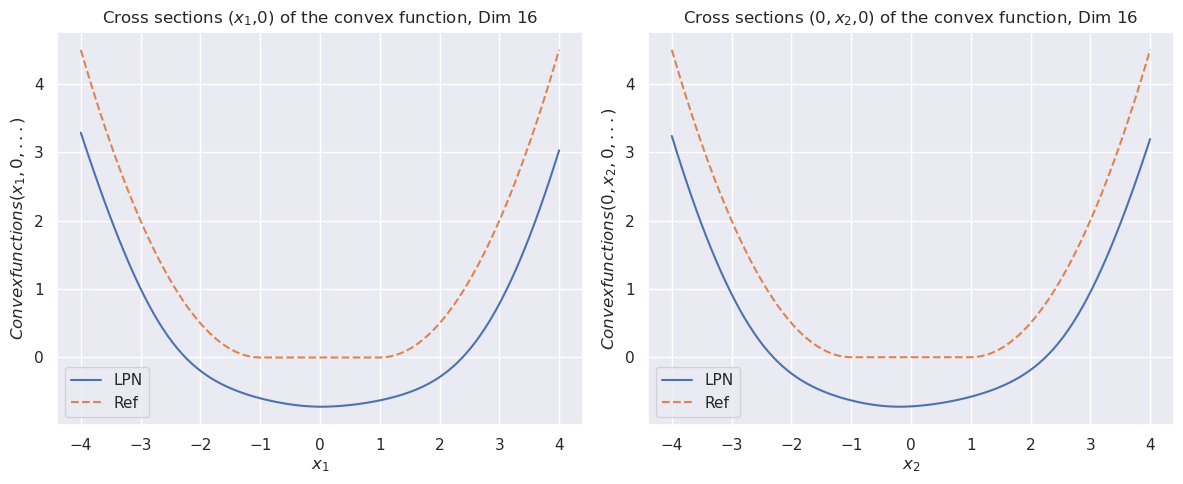

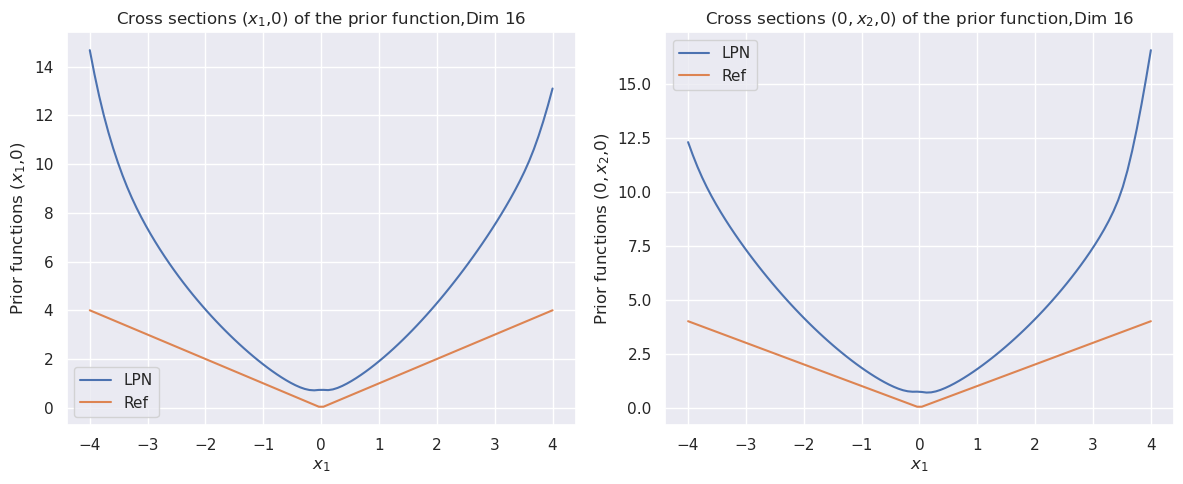

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1295.03515625
iteration 0 loss 104.31583404541016


iteration 5000 loss 0.9626588821411133


iteration 10000 loss 0.08203808963298798


iteration 15000 loss 0.0404483899474144


iteration 20000 loss 0.030783915892243385


iteration 25000 loss 0.0259903222322464


iteration 30000 loss 0.022232288494706154


iteration 35000 loss 0.01961330510675907


iteration 40000 loss 0.017677390947937965


iteration 45000 loss 0.015791911631822586


iteration 50000 loss 0.01455205213278532


iteration 55000 loss 0.01330513134598732


iteration 60000 loss 0.012375805526971817


iteration 65000 loss 0.011437258683145046


iteration 70000 loss 0.01068783551454544


iteration 75000 loss 0.01000956166535616


iteration 80000 loss 0.009416479617357254


iteration 85000 loss 0.008901217952370644


iteration 90000 loss 0.008457041345536709


iteration 95000 loss 0.00804358720779419


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.0076674725860357285


iteration 105000 loss 0.007583292666822672


iteration 110000 loss 0.007248282432556152


iteration 115000 loss 0.0068385717459023


iteration 120000 loss 0.006550467107445002


iteration 125000 loss 0.006215554662048817


iteration 130000 loss 0.005996780935674906


iteration 135000 loss 0.0057526202872395515


iteration 140000 loss 0.005514357704669237


iteration 145000 loss 0.005336747970432043


iteration 150000 loss 0.005156397353857756


iteration 155000 loss 0.0049685947597026825


iteration 160000 loss 0.004811103455722332


iteration 165000 loss 0.004670285619795322


iteration 170000 loss 0.00450788764283061


iteration 175000 loss 0.0043718223460018635


iteration 180000 loss 0.004258692730218172


iteration 185000 loss 0.0041429428383708


iteration 190000 loss 0.004021278116852045


iteration 195000 loss 0.003900479059666395


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.003796554636210203


iteration 205000 loss 0.0037464138586074114


iteration 210000 loss 0.003638968802988529


iteration 215000 loss 0.003540297970175743


iteration 220000 loss 0.0034443398471921682


iteration 225000 loss 0.0033551000524312258


iteration 230000 loss 0.003271193942055106


iteration 235000 loss 0.0031893427949398756


iteration 240000 loss 0.003112081903964281


iteration 245000 loss 0.0030392620246857405


iteration 250000 loss 0.002970068948343396


iteration 255000 loss 0.0029001685325056314


iteration 260000 loss 0.002835571300238371


iteration 265000 loss 0.002771645551547408


iteration 270000 loss 0.0027123771142214537


iteration 275000 loss 0.002653094008564949


iteration 280000 loss 0.0026012121234089136


iteration 285000 loss 0.002549019642174244


iteration 290000 loss 0.0024967787321656942


iteration 295000 loss 0.0024472970981150866


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.0024003430735319853


iteration 305000 loss 0.0023915774654597044


iteration 310000 loss 0.0023757065646350384


iteration 315000 loss 0.0023600643035024405


iteration 320000 loss 0.002344901440665126


iteration 325000 loss 0.0023300985340029


iteration 330000 loss 0.002315605292096734


iteration 335000 loss 0.0023013800382614136


iteration 340000 loss 0.002287399722263217


iteration 345000 loss 0.002273650374263525


iteration 350000 loss 0.002260120352730155


iteration 355000 loss 0.002246785443276167


iteration 360000 loss 0.0022336370311677456


iteration 365000 loss 0.0022206641733646393


iteration 370000 loss 0.0022078503388911486


iteration 375000 loss 0.0021951780654489994


iteration 380000 loss 0.0021826615557074547


iteration 385000 loss 0.002170283580198884


iteration 390000 loss 0.0021580515895038843


iteration 395000 loss 0.0021459516137838364


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.002133984351530671


iteration 405000 loss 0.002133115427568555


iteration 410000 loss 0.0021322062239050865


iteration 415000 loss 0.0021313095930963755


iteration 420000 loss 0.0021304229740053415


iteration 425000 loss 0.0021295456681400537


iteration 430000 loss 0.0021286753471940756


iteration 435000 loss 0.0021278141066432


iteration 440000 loss 0.0021269526332616806


iteration 445000 loss 0.0021261011715978384


iteration 450000 loss 0.002125250408425927


iteration 455000 loss 0.002124401740729809


iteration 460000 loss 0.002123560756444931


iteration 465000 loss 0.0021227251272648573


iteration 470000 loss 0.0021218908950686455


iteration 475000 loss 0.002121059922501445


iteration 480000 loss 0.002120234305039048


iteration 485000 loss 0.0021194128785282373


iteration 490000 loss 0.0021185935474932194


iteration 495000 loss 0.002117773052304983


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


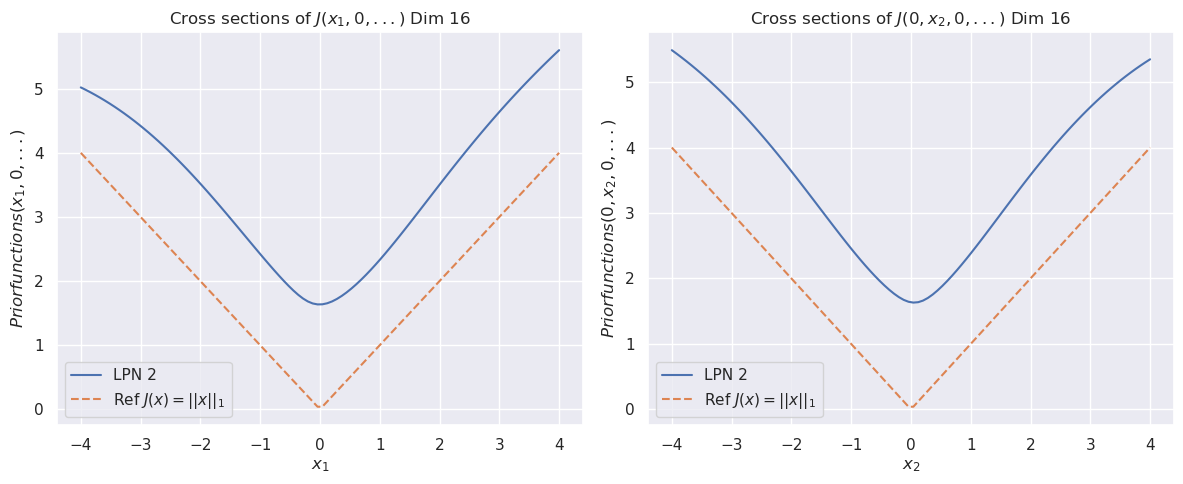

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions (x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions #(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)